# Trying to implement Karl Stratos Mini Tagger Approach

# Trying to split things out JIAYOU WINNIE

In [71]:
import argparse
import collections
import datetime
import math
import numpy
import os
import pickle
import random
import subprocess
import sys
import time

path = "liblinear-1.96/python"
sys.path.append(os.path.abspath(path))

import liblinearutil

In [72]:
FRONT_BUFFER_SYMBOL = "_START_"  # For sentence boundaries
END_BUFFER_SYMBOL = "_END_"  # For sentence boundaries
UNKNOWN_SYMBOL = "<?>"   # For unknown observation types at test time

global SPELLING_FEATURE_CACHE
SPELLING_FEATURE_CACHE = {}

In [73]:
def clear_spelling_feature_cache():
    """Clears the global spelling feature cache."""
    global SPELLING_FEATURE_CACHE
    SPELLING_FEATURE_CACHE = {}
    
def get_word(word_sequence, position):
    """Gets the word at the specified position."""
    if position < 0:
        return FRONT_BUFFER_SYMBOL
    elif position >= len(word_sequence):
        return END_BUFFER_SYMBOL
    else:
        return word_sequence[position]

def is_capitalized(word):
    """Is the word capitalized?"""
    return word[0].isupper()

def get_prefix(word, length):
    """Gets a padded prefix of the word up to the given length."""
    prefix = ""
    for i in range(length):
        if i < len(word):
            prefix += word[i]
        else:
            prefix += "*"
    return prefix

def get_suffix(word, length):
    """Gets a padded suffix of the word up to the given length."""
    suffix = ""
    for i in range(length):
        if i < len(word):
            suffix = word[-i-1] + suffix
        else:
            suffix = "*" + suffix
    return suffix

def is_all_nonalphanumeric(word):
    """Is the word all nonalphanumeric?"""
    for char in word:
        if char.isalnum():
            return False
    return True

def is_float(word):
    """Can the word be converted to a float (i.e., numeric value)?"""
    try:
        float(word)
        return True
    except ValueError:
        return False

def spelling_features(word, relative_position):
    """
    Extracts spelling features about the given word. Also considers the word's
    relative position.
    """
    if not (word, relative_position) in SPELLING_FEATURE_CACHE:
        features = {}
        features["word({0})={1}".format(relative_position, word)] = 1
        features['is_capitalized({0})={1}'.format(
                relative_position, is_capitalized(word))] = 1
        for length in range(1, 5):
            features["prefix{0}({1})={2}".format(
                    length, relative_position, get_prefix(word, length))] = 1
            features["suffix{0}({1})={2}".format(
                    length, relative_position, get_suffix(word, length))] = 1
        features["is_all_nonalphanumeric({0})={1}".format(
                relative_position, is_all_nonalphanumeric(word))] = 1
        features["is_float({0})={1}".format(
                relative_position, is_float(word))] = 1
        SPELLING_FEATURE_CACHE[(word, relative_position)] = features

    # Return a copy so that modifying that object doesn't modify the cache.
    return SPELLING_FEATURE_CACHE[(word, relative_position)].copy()

def get_baseline_features(word_sequence, position): 
    word = get_word(word_sequence, position)
    word_left1 = get_word(word_sequence, position - 1)
    word_left2 = get_word(word_sequence, position - 2)
    word_right1 = get_word(word_sequence, position + 1)
    word_right2 = get_word(word_sequence, position + 2)
    features = spelling_features(word, 0)
    features["word(-1)={0}".format(word_left1)] = 1
    features["word(-2)={0}".format(word_left2)] = 1
    features["word(+1)={0}".format(word_right1)] = 1
    features["word(+2)={0}".format(word_right2)] = 1
    
    return features

In [74]:
__map_label_str2num = {}
__map_label_num2str = {}
__map_feature_str2num = {}
__map_feature_num2str = {}

In [75]:
print("__map_label_str2num", __map_label_str2num)
print("__map_label_num2str", __map_label_num2str)
print("__map_feature_str2num", __map_feature_str2num)
print("__map_feature_num2str", __map_feature_num2str)

__map_label_str2num {}
__map_label_num2str {}
__map_feature_str2num {}
__map_feature_num2str {}


In [76]:
def __get_label(label):
    """
    When this function is being called, it will append a new label into the dictionary.
    If the label already exist in the function, it will just return the label in integer value. 
    Universal tagset will return 1-12. 
    """
    if not label in __map_label_str2num:
        label_number = len(__map_label_str2num) + 1  # index from 1
        __map_label_str2num[label] = label_number
        __map_label_num2str[label_number] = label
    return __map_label_str2num[label]

In [77]:
# feature_template = "baseline" 
# feature_template = "embedding" 
feature_template = "bitstring" 

__word_embedding = None
__word_bitstring = None

In [78]:
# load the bit string file 
# importing the module
import json
  
# reading the data from the file
with open('c_train_latest_bitstring_dict.txt') as f:
    data = f.read()

print("Data type before reconstruction : ", type(data))
      
# reconstructing the data as a dictionary
__word_bitstring = json.loads(data)
  
print("Data type after reconstruction : ", type(__word_bitstring))
print(len(__word_bitstring))

Data type before reconstruction :  <class 'str'>
Data type after reconstruction :  <class 'dict'>
15506


In [79]:
def num_feature_types():
    return len(__map_feature_str2num)

def get_feature_string(feature_number):
    return __map_feature_num2str[feature_number]

def get_label_string(label_number):
    return __map_label_num2str[label_number]

def get_feature_number(feature_string):
    return __map_feature_str2num[feature_string]

def get_label_number(label_string):
    return __map_label_str2num[label_string]

In [80]:
def __get_features(observation_sequence, position):
    if feature_template == "baseline":
        raw_features = get_baseline_features(observation_sequence, position)
    elif feature_template == "embedding":
        assert __word_embedding is not None
        raw_features = get_embedding_features(observation_sequence, position, __word_embedding)
    elif feature_template == "bitstring":
        assert __word_bitstring is not None
        raw_features = get_bitstring_features(observation_sequence, position, __word_bitstring)
    else:
        raise Exception("Unsupported feature template {0}".format(feature_template))
        
    numeric_features = {}
    for raw_feature in raw_features:
        
        if not raw_feature in __map_feature_str2num:
            feature_number = len(__map_feature_str2num) + 1
            __map_feature_str2num[raw_feature] = feature_number
            __map_feature_num2str[feature_number] = raw_feature
            
        numeric_features[__map_feature_str2num[raw_feature]] = raw_features[raw_feature]
        
    return numeric_features

In [81]:
def get_bitstring_features(word_sequence, position, bitstring_dictionary):
    """
    Bit string features: baseline features + bit strings of current, left, and
    right words.
    """
    # Compute the baseline feature vector.
    features = get_baseline_features(word_sequence, position)

    # Add the bit string features.
    word = word_sequence[position]  # current word
    if word in bitstring_dictionary:
        word_bitstring = bitstring_dictionary[word]
    else:
        word_bitstring = bitstring_dictionary[UNKNOWN_SYMBOL]
        # word_bitstring = "0"
    for i in range(1, len(word_bitstring) + 1):
        features["bitstring(0)_prefix({0})={1}".format(
                i, word_bitstring[:i])] = 1
    features["bitstring(0)_all={0}".format(word_bitstring)] = 1

    if position > 0:
        word = word_sequence[position - 1]  # word to the left
        if word in bitstring_dictionary:
            word_bitstring = bitstring_dictionary[word]
        else:
            word_bitstring = bitstring_dictionary[UNKNOWN_SYMBOL]
            # word_bitstring = "0"
        for i in range(1, len(word_bitstring) + 1):
            features["bitstring(-1)_prefix({0})={1}".format(
                    i, word_bitstring[:i])] = 1
        features["bitstring(-1)_all={0}".format(word_bitstring)] = 1

    if position < len(word_sequence) - 1:
        word = word_sequence[position + 1]  # word to the right
        if word in bitstring_dictionary:
            word_bitstring = bitstring_dictionary[word]
        else:
            word_bitstring = bitstring_dictionary[UNKNOWN_SYMBOL]
            # word_bitstring = "0"
        for i in range(1, len(word_bitstring) + 1):
            features["bitstring(+1)_prefix({0})={1}".format(
                    i, word_bitstring[:i])] = 1
        features["bitstring(+1)_all={0}".format(word_bitstring)] = 1

    return features

In [82]:
def extract_features(sequence_data, extract_all, skip_list): 
    label_list = []
    features_list = []
    location_list = []
    
    for sequence_num, (observation_sequence, label_sequence) in enumerate(sequence_data):
        for position, label in enumerate(label_sequence):
            
            if skip_list and skip_list[sequence_num][position]:
                continue 
                
            if (not label is None) or extract_all:
                label_list.append(__get_label(label))
                features_list.append(__get_features(observation_sequence, position))
                location_list.append((sequence_num, position))
                
    return label_list, features_list, location_list

In [83]:
def extract_features_only(token_list): 
    features_list = []
    
    for position, token in enumerate(token_list[0]):
        features_list.append(__get_features(token, position))

    return features_list
# return label_list, features_list, location_list

In [84]:
def predict(data_test):
    # print(data_test)
    start_time = time.time()
    [label_list, features_list, _] = extract_features(data_test, True, [])
    # print(label_list)
    # print(features_list)
    
    pred_labels, (acc, _, _), _ = liblinearutil.predict(label_list, features_list, __liblinear_model, "-q")
    
#     print(pred_labels)
#     print(acc)
#     print(_)
    
    
    num_seconds = int(math.ceil(time.time() - start_time))
    print("Prediction time: {0}".format(str(datetime.timedelta(seconds=num_seconds))))
            
    print("Per-instance accuracy: {0:.3f}%".format(acc))
    
    for i, label in enumerate(pred_labels):
        pred_labels[i] = get_label_string(label)
    return pred_labels, acc

In [85]:
def train(label_list, features_list):
    """Trains Minitagger on the given data."""
    start_time = time.time()
  
    problem = liblinearutil.problem(label_list, features_list)
    __liblinear_model = \
        liblinearutil.train(problem, liblinearutil.parameter("-q"))
      
    quiet = False
    if not quiet:
        num_seconds = int(math.ceil(time.time() - start_time))
        print("Training time: {0}".format(
            str(datetime.timedelta(seconds=num_seconds))))
        if features_list is not None:
            quiet_value = quiet
            quiet = True
            _, acc = predict(label_list, features_list)
            quiet = quiet_value
            print("Dev accuracy: {0:.3f}%".format(acc))


In [46]:
# amendment proposed on 17 Oct 2022 
def extract_multiple_sentences_features(sequence_data, extract_all, skip_list): 
    label_list = []
    features_list = []
    location_list = []
    print(len(sequence_data))
    for sequence_num, (observation_sequence, label_sequence) in enumerate(sequence_data):
        sent_label_list = []
        sent_feature_list = []
        sent_location_list = []
        for position, label in enumerate(label_sequence):
            
            if skip_list and skip_list[sequence_num][position]:
                continue 
            
            
            if (not label is None) or extract_all:
                sent_label_list.append(__get_label(label))
                sent_feature_list.append(__get_features(observation_sequence, position))
                sent_location_list.append((sequence_num, position))
        label_list.append(sent_label_list)
        features_list.append(sent_feature_list)
        location_list.append(sent_location_list)
                
    return label_list, features_list, location_list

sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN', 'AUX', 'ADJ', 'DET', 'NOUN']],
                  [['This', 'is', 'me'],['DET','AUX','PRON']]]
label_list, features_list, _ = extract_multiple_sentences_features(sequence_pairs, False, [])
print("label_list: ", label_list)
print("len(label_list): ", len(label_list))
print("len(features_list): ", len(features_list))
print("features_list: ", features_list)
# sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN', 'AUX', 'ADJ', 'DET', 'NOUN']]]
# sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN',None,  'ADJ', 'DET', 'NOUN']]]
# data_train = [[['The', 'dog', 'saw', 'the', 'cat'], ['D', 'N', 'V', 'D', 'N']]]
print("\nbreakline\n")

UNKNOWN_SYMBOL = "<?>"   # For unknown observation types at test time
sequence_pairs = [[['The', 'dog', 'saw', 'the', 'cat'], ['D', 'N', 'V', 'D', 'N']]]
label_list, features_list, _ = extract_multiple_sentences_features(sequence_pairs, False, [])
print("label_list: ", label_list)
print("len(label_list): ", len(label_list))
print("len(features_list): ", len(features_list))
print("features_list: ", features_list)

2
label_list:  [[1, 2, 3, 4, 5], [4, 2, 6]]
len(label_list):  2
len(features_list):  2
features_list:  [[{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1}, {17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 11: 1, 12: 1, 27: 1, 14: 1, 28: 1, 29: 1}, {30: 1, 18: 1, 31: 1, 4: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 11: 1, 12: 1, 38: 1, 39: 1, 40: 1, 41: 1}, {42: 1, 18: 1, 43: 1, 4: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 11: 1, 12: 1, 50: 1, 51: 1, 52: 1, 53: 1}, {54: 1, 18: 1, 31: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 11: 1, 12: 1, 62: 1, 63: 1, 64: 1, 53: 1}], [{65: 1, 2: 1, 66: 1, 20: 1, 67: 1, 22: 1, 68: 1, 69: 1, 70: 1, 71: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 72: 1}, {17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 11: 1, 12: 1, 73: 1, 14: 1, 74: 1, 53: 1}, {75: 1, 18: 1, 76: 1, 4: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 11: 1, 12: 1, 38: 1, 83: 1, 64: 1, 53

In [47]:
label_list

[[7, 8, 9, 7, 8]]

In [48]:
# the liblinear package is not design to handle problem/training data with the format 
# [[{},{}, {}], [{},{}]]

print("{0} labeled instances (out of {1})".format(len(label_list), len(features_list)))
print("{0} label types".format(len(label_list)))
print("{0} observation types".format(len(sequence_pairs[0][0])))

problem = liblinearutil.problem(label_list, features_list)
__liblinear_model = liblinearutil.train(problem, liblinearutil.parameter("-q"))

data_dev = [[['The', 'rabbit', 'ate', 'a', 'zebra'], ['DET', 'NOUN', 'VERB', 'DET', 'NOUN']]]
# data_dev = [[['The', 'rabbit', 'ate', 'a', 'zebra'], ['DET', '', 'VERB', 'DET', 'NOUN']]]
_, acc = predict(data_dev)

1 labeled instances (out of 1)
1 label types
5 observation types


TypeError: must be real number, not dict

# - END OF "MUST DECLARE PART"

# PERFORMING PREDICTION WITHOUT TAG BEING PASS IN

In [20]:
import pandas as pd
sentences = ["cat and dog", "this is second"]
df = pd.DataFrame(sentences, columns=['sentence'])
df['sentence'] = df['sentence'].apply(lambda x: [x.split(), []])
df['features'] = df['sentence'].apply(extract_features_only)
# print(df.to_markdown(table_fmt='grid'))
df.head()

,sentence,features
0,"[[cat, and, dog], []]","[{116: 1, 18: 1, 31: 1, 117: 1, 118: 1, 119: 1..."
1,"[[this, is, second], []]","[{147: 1, 18: 1, 43: 1, 55: 1, 148: 1, 149: 1,..."


In [21]:
df['y_pred'] = df['features'].apply(lambda x: liblinearutil.predict_only(x, __liblinear_model, "-q"))
df

NameError: name '__liblinear_model' is not defined

In [ ]:
get_label_string(3)

In [41]:
get_label_string(13)

'X'

In [42]:
get_label_string(6)

'PROPN'

In [43]:
get_label_string(4)

'ADJ'

In [47]:
liblinearutil.predict_only(features_list, __liblinear_model, "-q")

[1.0,
 2.0,
 3.0,
 4.0,
 3.0,
 5.0,
 6.0,
 6.0,
 7.0,
 4.0,
 3.0,
 8.0,
 9.0,
 2.0,
 6.0,
 5.0,
 6.0,
 5.0,
 6.0,
 5.0,
 10.0,
 6.0,
 6.0,
 1.0,
 2.0,
 3.0,
 2.0,
 11.0,
 9.0,
 4.0,
 3.0,
 4.0,
 3.0,
 1.0,
 3.0,
 1.0,
 12.0,
 4.0,
 4.0,
 3.0,
 3.0,
 1.0,
 1.0,
 2.0,
 3.0,
 5.0,
 12.0,
 8.0,
 2.0,
 7.0,
 9.0,
 2.0,
 4.0,
 3.0,
 3.0,
 3.0,
 13.0,
 5.0,
 9.0,
 4.0,
 5.0,
 4.0,
 1.0,
 8.0,
 11.0,
 8.0,
 8.0,
 4.0,
 3.0,
 3.0,
 1.0,
 4.0,
 3.0,
 5.0,
 4.0,
 3.0,
 3.0,
 5.0,
 4.0,
 3.0,
 1.0,
 3.0,
 5.0,
 4.0,
 3.0,
 1.0,
 3.0,
 5.0,
 12.0,
 11.0,
 8.0,
 9.0,
 6.0,
 3.0,
 1.0,
 12.0,
 12.0,
 11.0,
 8.0,
 4.0,
 3.0,
 10.0,
 9.0,
 5.0,
 5.0,
 5.0,
 4.0,
 3.0,
 5.0,
 4.0,
 3.0,
 5.0,
 4.0,
 3.0,
 3.0,
 5.0,
 4.0,
 3.0,
 9.0,
 8.0,
 9.0,
 5.0,
 10.0,
 8.0,
 1.0,
 9.0,
 4.0,
 5.0,
 4.0,
 1.0,
 12.0,
 3.0,
 5.0,
 4.0,
 1.0,
 12.0,
 3.0,
 3.0,
 1.0,
 3.0,
 5.0,
 3.0,
 8.0,
 4.0,
 5.0,
 2.0,
 3.0,
 8.0,
 4.0,
 5.0,
 2.0,
 3.0,
 8.0,
 4.0,
 1.0,
 5.0,
 12.0,
 8.0,
 2.0,
 11.0,
 8.0,
 12.0,
 1.0,
 12.

#  END OF PERFORMING PREDICTION WITHOUT TAG BEING PASS IN

In [86]:
sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN', 'AUX', 'ADJ', 'DET', 'NOUN']]]
# sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN', 'AUX', 'ADJ', 'DET', 'NOUN']]]
# sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN',None,  'ADJ', 'DET', 'NOUN']]]
# data_train = [[['The', 'dog', 'saw', 'the', 'cat'], ['D', 'N', 'V', 'D', 'N']]]
# sequence_pairs = [[['The', 'dog', 'saw', 'the', 'cat'], ['D', 'N', 'V', 'D', 'N']]]

In [87]:
label_list, features_list, _ = extract_features(sequence_pairs, False, [])

In [88]:
label_list

[1, 2, 3, 4, 5]

In [89]:
features_list

[{1: 1,
  2: 1,
  3: 1,
  4: 1,
  5: 1,
  6: 1,
  7: 1,
  8: 1,
  9: 1,
  10: 1,
  11: 1,
  12: 1,
  13: 1,
  14: 1,
  15: 1,
  16: 1,
  17: 1,
  18: 1,
  19: 1,
  20: 1,
  21: 1,
  22: 1,
  23: 1,
  24: 1,
  25: 1,
  26: 1,
  27: 1,
  28: 1,
  29: 1,
  30: 1,
  31: 1,
  32: 1,
  33: 1,
  34: 1,
  35: 1,
  36: 1,
  37: 1,
  38: 1,
  39: 1,
  40: 1,
  41: 1,
  42: 1,
  43: 1,
  44: 1,
  45: 1,
  46: 1,
  47: 1,
  48: 1,
  49: 1,
  50: 1,
  51: 1,
  52: 1,
  53: 1,
  54: 1,
  55: 1,
  56: 1,
  57: 1,
  58: 1,
  59: 1,
  60: 1,
  61: 1,
  62: 1,
  63: 1,
  64: 1,
  65: 1,
  66: 1,
  67: 1,
  68: 1,
  69: 1,
  70: 1,
  71: 1,
  72: 1,
  73: 1,
  74: 1,
  75: 1,
  76: 1,
  77: 1,
  78: 1,
  79: 1,
  80: 1,
  81: 1,
  82: 1,
  83: 1,
  84: 1,
  85: 1,
  86: 1,
  87: 1,
  88: 1,
  89: 1,
  90: 1,
  91: 1,
  92: 1,
  93: 1,
  94: 1,
  95: 1,
  96: 1,
  97: 1,
  98: 1,
  99: 1,
  100: 1,
  101: 1,
  102: 1,
  103: 1,
  104: 1,
  105: 1,
  106: 1,
  107: 1,
  108: 1,
  109: 1,
  110: 1,
  111: 1

In [90]:
_

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]

In [91]:
len(features_list)

5

In [92]:
# print("{0} labeled instances (out of {1})".format(len(label_list), data_train.num_instances))
# print("{0} label types".format(len(data_train.label_count)))
# print("{0} observation types".format(len(data_train.observation_count)))
# print("\"{0}\" feature template".format(self.__feature_extractor.feature_template))
# print("{0} feature types".format(self.__feature_extractor.num_feature_types()))

In [93]:
print("{0} labeled instances (out of {1})".format(len(label_list), len(features_list)))
print("{0} label types".format(len(label_list)))
print("{0} observation types".format(len(sequence_pairs[0][0])))

5 labeled instances (out of 5)
5 label types
5 observation types


In [94]:
problem = liblinearutil.problem(label_list, features_list)

In [95]:
temp = features_list[0:2]

In [96]:
temp[0].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [97]:
temp[0].values()

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [98]:
features_list_ = []
for features in temp:
    empty_dict = {}
    for i in features.items():
        keys = i[0]
        feature_key = get_feature_string(keys)
        values = i[1]
        print(feature_key, values)
    # keys = 
    # values = 
    # empty_dict.update({"color": "red"}) 
    print(features)
    print("")
    # features_list.append(get_feature_string(label))

word(0)=Winnie 1
is_capitalized(0)=True 1
prefix1(0)=W 1
suffix1(0)=e 1
prefix2(0)=Wi 1
suffix2(0)=ie 1
prefix3(0)=Win 1
suffix3(0)=nie 1
prefix4(0)=Winn 1
suffix4(0)=nnie 1
is_all_nonalphanumeric(0)=False 1
is_float(0)=False 1
word(-1)=_START_ 1
word(-2)=_START_ 1
word(+1)=is 1
word(+2)=cute 1
bitstring(0)_prefix(1)=1 1
bitstring(0)_prefix(2)=11 1
bitstring(0)_prefix(3)=110 1
bitstring(0)_prefix(4)=1100 1
bitstring(0)_prefix(5)=11000 1
bitstring(0)_prefix(6)=110000 1
bitstring(0)_prefix(7)=1100000 1
bitstring(0)_prefix(8)=11000000 1
bitstring(0)_prefix(9)=110000000 1
bitstring(0)_prefix(10)=1100000000 1
bitstring(0)_prefix(11)=11000000000 1
bitstring(0)_prefix(12)=110000000000 1
bitstring(0)_prefix(13)=1100000000000 1
bitstring(0)_prefix(14)=11000000000000 1
bitstring(0)_prefix(15)=110000000000000 1
bitstring(0)_prefix(16)=1100000000000000 1
bitstring(0)_prefix(17)=11000000000000000 1
bitstring(0)_prefix(18)=110000000000000000 1
bitstring(0)_prefix(19)=1100000000000000000 1
bitstring(

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [99]:
label_list

[1, 2, 3, 4, 5]

In [100]:
__liblinear_model = liblinearutil.train(problem, liblinearutil.parameter("-q"))

In [101]:
data_dev = [[['The', 'rabbit', 'ate', 'a', 'zebra'], ['DET', 'NOUN', 'VERB', 'DET', 'NOUN']],
           [['This', 'is', 'me'],['DET','AUX','PRON']]]
# data_dev = [[['The', 'rabbit', 'ate', 'a', 'zebra'], ['DET', '', 'VERB', 'DET', 'NOUN']]]

In [102]:
_, acc = predict(data_dev)

Prediction time: 0:00:01
Per-instance accuracy: 37.500%


In [103]:
print("predicted labels: ", _)
print(acc)

predicted labels:  ['ADJ', 'DET', 'NOUN', 'DET', 'NOUN', 'ADJ', 'AUX', 'ADJ']
37.5


In [104]:
data_dev = [[['I', 'am', 'Winnie'], ['PRON', 'AUX', 'PROPN']]]
_, acc = predict(data_dev)

Prediction time: 0:00:01
Per-instance accuracy: 0.000%


In [105]:
print("predicted labels: ", _)
print(acc)

predicted labels:  ['ADJ', 'DET', 'DET']
0.0


In [106]:
data_dev = [[['Jay', 'is', 'Winnie'], ['', '', '']]]
_, acc = predict(data_dev)

Prediction time: 0:00:01
Per-instance accuracy: 0.000%


In [107]:
print("predicted labels: ", _)

predicted labels:  ['PROPN', 'AUX', 'PROPN']


# About prediction (function)

In [24]:
def predict(data_test):
    # print(data_test)
    start_time = time.time()
    [label_list, features_list, _] = extract_features(data_test, True, [])
    print(label_list)
    print(features_list)
    
    pred_labels, (acc, _, _), _ = liblinearutil.predict(label_list, features_list, __liblinear_model, "-q")
    
    print(pred_labels)
    print(acc)
    print(_)
    
    
    num_seconds = int(math.ceil(time.time() - start_time))
    print("Prediction time: {0}".format(str(datetime.timedelta(seconds=num_seconds))))
            
    print("Per-instance accuracy: {0:.3f}%".format(acc))
    
    for i, label in enumerate(pred_labels):
        pred_labels[i] = get_label_string(label)
    return pred_labels, acc

In [25]:
def train(label_list, features_list):
    """Trains Minitagger on the given data."""
    start_time = time.time()
  
    problem = liblinearutil.problem(label_list, features_list)
    __liblinear_model = \
        liblinearutil.train(problem, liblinearutil.parameter("-q"))
      
    quiet = False
    if not quiet:
        num_seconds = int(math.ceil(time.time() - start_time))
        print("Training time: {0}".format(
            str(datetime.timedelta(seconds=num_seconds))))
        if features_list is not None:
            quiet_value = quiet
            quiet = True
            _, acc = predict(label_list, features_list)
            quiet = quiet_value
            print("Dev accuracy: {0:.3f}%".format(acc))


In [352]:
# def predict(label_list, features_list):
#     start_time = time.time()

#         # Extract features (on all instances, labeled or unlabeled) and pass
#         # them to liblinear for prediction.
#     pred_labels, (acc, _, _), _ = \
#         liblinearutil.predict(label_list, features_list,
#                                 __liblinear_model, "-q")
#     quiet = False
#     if not quiet:
#         num_seconds = int(math.ceil(time.time() - start_time))
        
#         print("Prediction time: {0}".format(str(datetime.timedelta(seconds=num_seconds))))


#         # Convert predicted labels from integer IDs to strings.
#     for i, label in enumerate(pred_labels):
#         pred_labels[i] == label
#     return pred_labels, acc


# TRAIN THE MODEL USING FINALIZED DATASET BY ANDREW & WINNIE (train_latest.csv & test_latest.csv)

In [60]:
import pandas as pd
df = pd.read_csv("train_latest.csv")
df.head()

import ast
def convert_string2_list(text):
    return ast.literal_eval(str(text))

data = df.tagged.apply(convert_string2_list)
data = data.to_list()

# train test split 
cutoff = int(.80 * len(data))
training_sentences = data[:cutoff]
test_sentences = data[cutoff:]

# all these data are in the format of listof tuple
# a function to change them into list of list is required 

def convert_listoftuples_to_listoflists(listoftuples):
    training_data = []
    for each_sentences in listoftuples: 
        observation_list = []
        label_list = []
        for i in each_sentences:
            observation = i[0]
            observation_list.append(observation)
            label = i[1]
            label_list.append(label)
        sentence_list = [observation_list,label_list]
        training_data.append(sentence_list)
    return training_data

data_train = convert_listoftuples_to_listoflists(training_sentences)
data_dev = convert_listoftuples_to_listoflists(test_sentences)

# rese4t all these values
__map_label_str2num = {}
__map_label_num2str = {}
__map_feature_str2num = {}
__map_feature_num2str = {}

__map_label_str2num

label_list, features_list, _ = extract_features(data_train, False, [])

len(features_list)
len(label_list)

print("{0} labeled instances (out of {1})".format(len(label_list), len(features_list)))
print("{0} label types".format(len(label_list)))

problem = liblinearutil.problem(label_list, features_list)

79881 labeled instances (out of 79881)
79881 label types


In [61]:
unqiue_lebel = set(label_list)
final_label = []
for label in unqiue_lebel:
    final_label.append(get_label_string(label))
final_label

['ADP',
 'DET',
 'NOUN',
 'ADJ',
 'PUNCT',
 'PROPN',
 'PART',
 'VERB',
 'ADV',
 'CCONJ',
 'AUX',
 'PRON',
 'X',
 'INTJ',
 'SCONJ',
 'NUM',
 'SYM']

In [62]:
len(final_label)

17

In [37]:
__liblinear_model = liblinearutil.train(problem, liblinearutil.parameter("-q"))
_, acc = predict(data_dev)

Prediction time: 0:00:01
Per-instance accuracy: 96.206%


In [132]:
def compile_y_true(data_dev):
    y_true = []
    for sent in data_dev:
        pos_list = sent[1]
        y_true += pos_list
    return y_true

In [135]:
true_label = compile_y_true(data_dev)

In [136]:
len(true_label)

29998

In [119]:
acc

96.18974598306554

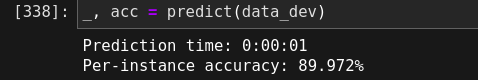

### using baselines feature and baseline training
## should do some ammendment in the code so that can get all the performance 

In [124]:
labels = set(final_label)
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [125]:
sorted_labels

['X',
 'PART',
 'CCONJ',
 'SCONJ',
 'ADJ',
 'ADP',
 'ADV',
 'VERB',
 'DET',
 'INTJ',
 'NOUN',
 'PRON',
 'PROPN',
 'NUM',
 'PUNCT',
 'AUX',
 'SYM']

In [141]:
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

y_pred = _
y_true = true_label
print(classification_report(y_true, y_pred, labels=sorted_labels))


              precision    recall  f1-score   support

           X       0.99      1.00      1.00      1979
        PART       1.00      1.00      1.00       965
       CCONJ       0.99      0.99      0.99       646
       SCONJ       0.00      0.00      0.00         0
         ADJ       0.86      0.83      0.85      1916
         ADP       0.98      0.98      0.98      3022
         ADV       0.87      0.89      0.88       859
        VERB       0.96      0.95      0.95      4085
         DET       0.99      0.99      0.99      2813
        INTJ       0.00      0.00      0.00         1
        NOUN       0.94      0.95      0.94      6017
        PRON       0.97      1.00      0.99       529
       PROPN       0.96      0.95      0.96      2516
         NUM       0.99      0.99      0.99      1278
       PUNCT       1.00      1.00      1.00      3161
         AUX       0.00      0.00      0.00         0
         SYM       1.00      1.00      1.00       211

    accuracy              

## Remarks

It seems very accurate because the metric compiled is per token not per sentence. 

In [148]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
y_true_ = np.array(y_true)
y_pred_ = np.array(y_pred)
precision_recall_fscore_support(y_true_, y_pred_, average='weighted')

(0.961879405294209, 0.9618974598306553, 0.9618503182930421, None)

In [150]:
len(y_pred)

29998

In [151]:
len(y_true)

29998

In [152]:
from sklearn.metrics import classification_report
import sklearn_crfsuite.metrics as metrics

y_pred = _
y_true = true_label

print('F1 score on the test set = {}\n'.format(metrics.flat_f1_score(y_true, y_pred, labels=labels, average='weighted')))
print('Accuracy on the test set = {}\n'.format(metrics.flat_accuracy_score(y_true, y_pred)))
print('Precision on the test set = {}\n'.format(metrics.flat_precision_score(y_true, y_pred, labels=labels, average='weighted')))
print('Recall on the test set = {}\n'.format(metrics.flat_recall_score(y_true, y_pred,labels=labels, average='weighted')))


ValueError: Found input variables with inconsistent numbers of samples: [110279, 110303]

In [53]:
import pandas as pd
df = pd.read_csv("train_latest.csv")
df.head()
def convert_string2_list(text):
    return ast.literal_eval(str(text))

data = df.tagged.apply(convert_string2_list)
data = data.to_list()

# train test split 
cutoff = int(.80 * len(data))
training_sentences = data[:cutoff]
test_sentences = data[cutoff:]

# all these data are in the format of listof tuple
# a function to change them into list of list is required 

def convert_listoftuples_to_listoflists(listoftuples):
    training_data = []
    for each_sentences in listoftuples: 
        observation_list = []
        label_list = []
        for i in each_sentences:
            observation = i[0]
            observation_list.append(observation)
            label = i[1]
            label_list.append(label)
        sentence_list = [observation_list,label_list]
        training_data.append(sentence_list)
    return training_data

data_train = convert_listoftuples_to_listoflists(training_sentences)
data_dev = convert_listoftuples_to_listoflists(test_sentences)

# rese4t all these values
__map_label_str2num = {}
__map_label_num2str = {}
__map_feature_str2num = {}
__map_feature_num2str = {}

label_list, features_list, _ = extract_features(data_train, False, [])

print("{0} labeled instances (out of {1})".format(len(label_list), len(features_list)))
print("{0} label types".format(len(label_list)))

problem = liblinearutil.problem(label_list, features_list)

__liblinear_model = liblinearutil.train(problem, liblinearutil.parameter("-q"))

_, acc = predict(data_dev)

79881 labeled instances (out of 79881)
79881 label types


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [54]:
acc

96.20308020534702

In [350]:
import pandas as pd
df = pd.read_csv("train_latest.csv")
df.head()
def convert_string2_list(text):
    return ast.literal_eval(str(text))

data = df.tagged.apply(convert_string2_list)
data = data.to_list()

# train test split 
cutoff = int(.80 * len(data))
training_sentences = data[:cutoff]
test_sentences = data[cutoff:]

# all these data are in the format of listof tuple
# a function to change them into list of list is required 

def convert_listoftuples_to_listoflists(listoftuples):
    training_data = []
    for each_sentences in listoftuples: 
        observation_list = []
        label_list = []
        for i in each_sentences:
            observation = i[0]
            observation_list.append(observation)
            label = i[1]
            label_list.append(label)
        sentence_list = [observation_list,label_list]
        training_data.append(sentence_list)
    return training_data

data_train = convert_listoftuples_to_listoflists(training_sentences)
data_dev = convert_listoftuples_to_listoflists(test_sentences)

# rese4t all these values
__map_label_str2num = {}
__map_label_num2str = {}
__map_feature_str2num = {}
__map_feature_num2str = {}

label_list, features_list, _ = extract_features(data_train, False, [])

print("{0} labeled instances (out of {1})".format(len(label_list), len(features_list)))
print("{0} label types".format(len(label_list)))

problem = liblinearutil.problem(label_list, features_list)

__liblinear_model = liblinearutil.train(problem, liblinearutil.parameter("-q"))

_, acc = predict(data_dev)

79881 labeled instances (out of 79881)
79881 label types
Prediction time: 0:00:02
Per-instance accuracy: 96.196%


In [55]:
import pandas as pd
df = pd.read_csv("test_latest.csv")

def convert_string2_list(text):
    return ast.literal_eval(str(text))

data = df.tagged.apply(convert_string2_list)
test_sentences = data.to_list()

data_test = convert_listoftuples_to_listoflists(test_sentences)

_, acc = predict(data_test)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [56]:
acc

82.17709259808281

# Testing on new sentences 

## required input and format 
a list of sentences to loop through, if there is only 1 sentence then it will process the only one sentence.

## process format 
convert it into list of list of list to perform prediction

## output 
the predicted pos tag for each word in the sentences.

In [67]:
input_data = ["She sells seashells on the seashore.", "I love planting.", "I am happy"]

In [77]:
from nltk.tokenize import sent_tokenize, word_tokenize

def convert_data(list_of_sentences):
    """convert sentence into the list of list of list format"""
    process_data_format = []
    
    for each_sentence in list_of_sentences:
        complete_list = []
        sentences_list = word_tokenize(each_sentence)
        # print(sentences_list)
        tag_list = [0] * len(sentences_list)
        # print(tag_list)
        complete_list.append(sentences_list)
        complete_list.append(tag_list)
        # print(complete_list)
        process_data_format.append(complete_list)
    return process_data_format
    

In [79]:
process_data = convert_data(input_data)

In [81]:
_, acc = predict(process_data)

[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
[{53302: 1, 2: 1, 227: 1, 168: 1, 1848: 1, 170: 1, 53303: 1, 53304: 1, 53305: 1, 53306: 1, 11: 1, 12: 1, 13: 1, 14: 1, 54936: 1, 126435: 1}, {54937: 1, 18: 1, 429: 1, 96: 1, 430: 1, 3564: 1, 810: 1, 3565: 1, 812: 1, 3566: 1, 11: 1, 12: 1, 53307: 1, 14: 1, 126436: 1, 1221: 1}, {126437: 1, 18: 1, 429: 1, 96: 1, 430: 1, 3564: 1, 831: 1, 3565: 1, 58287: 1, 3566: 1, 11: 1, 12: 1, 54939: 1, 53308: 1, 1229: 1, 154: 1}, {1230: 1, 18: 1, 348: 1, 4: 1, 1231: 1, 1232: 1, 1233: 1, 1234: 1, 1235: 1, 1236: 1, 11: 1, 12: 1, 126438: 1, 54941: 1, 165: 1, 126439: 1}, {167: 1, 18: 1, 156: 1, 168: 1, 169: 1, 170: 1, 171: 1, 172: 1, 173: 1, 174: 1, 11: 1, 12: 1, 1238: 1, 126440: 1, 126441: 1, 462: 1}, {126442: 1, 18: 1, 429: 1, 168: 1, 430: 1, 839: 1, 831: 1, 841: 1, 58287: 1, 49859: 1, 11: 1, 12: 1, 186: 1, 1240: 1, 470: 1, 471: 1}, {472: 1, 18: 1, 473: 1, 474: 1, 475: 1, 476: 1, 477: 1, 478: 1, 479: 1, 480: 1, 76: 1, 12: 1, 126443: 1, 190: 1, 482: 

In [84]:
process_data

[[['She', 'sells', 'seashells', 'on', 'the', 'seashore', '.'],
  [0, 0, 0, 0, 0, 0, 0]],
 [['I', 'love', 'planting', '.'], [0, 0, 0, 0]],
 [['I', 'am', 'happy'], [0, 0, 0]]]

In [86]:
_

['PRON',
 'VERB',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 'PUNCT',
 'PRON',
 'VERB',
 'VERB',
 'PUNCT',
 'PRON',
 'VERB',
 'ADJ']

In [374]:
def predict_output(data_test):

    [label_list, features_list, _] = extract_features(data_test, True, [])

    pred_labels, (acc, _, _), _ = liblinearutil.predict(label_list, features_list, __liblinear_model, "-q")
    
    for i, label in enumerate(pred_labels):
        pred_labels[i] = get_label_string(label)
    return pred_labels, acc

In [375]:
predict_output([['I', 'am', 'happy'],[None, None, None]])

ValueError: too many values to unpack (expected 2)

## NOT URGENT
# try to use sklearn libraries to perform training
## to observe the f-1 and precision score

# ABOUT ACTIVE TRAINING 

It seems like the author doing margin-based active learning, least confidence consider as margin based?

In [345]:
data_train = [[['I', 'am', 'Winnie'], ['PRON', 'AUX', 'PROPN']]]

__skip_extraction = []
for _, label_sequence in data_train:
    __skip_extraction.append([False for _ in label_sequence])

In [346]:
def __make_data_from_locations(data_train, locations):
    """The locations value will be something like [(0,0), (0,2)] and so on"""
    
    selected_positions = collections.defaultdict(list)
    
    for (sequence_num, position) in locations: 
        selected_positions[sequence_num].append(position)
    
    sequence_list = []
    
    for sequence_num in selected_positions: 
        word_sequence, label_sequence = data_train[sequence_num]
        selected_labels = [None for _ in range(len(word_sequence))]
        
        for position in selected_positions[sequence_num]:
            selected_labels[position] = label_sequence[position]
            __skip_extraction[sequence_num][position] = True
        sequence_list.append([word_sequence, selected_labels])
    
    
    # made some changes in the returning value 
    # prolly put something like 
    return sequence_list

In [ ]:
# the train function will required again 
def train(label_list, features_list):
    """Trains Minitagger on the given data."""
    start_time = time.time()
  
    problem = liblinearutil.problem(label_list, features_list)
    __liblinear_model = \
        liblinearutil.train(problem, liblinearutil.parameter("-q"))
      
    quiet = False
    if not quiet:
        num_seconds = int(math.ceil(time.time() - start_time))
        print("Training time: {0}".format(
            str(datetime.timedelta(seconds=num_seconds))))
        if features_list is not None:
            quiet_value = quiet
            quiet = True
            _, acc = predict(label_list, features_list)
            quiet = quiet_value
            print("Dev accuracy: {0:.3f}%".format(acc))


In [ ]:
def __train_silently(data_selected):
    """Trains on the argument data in silent mode."""
    self.__feature_extractor.is_training = True  # Reset for training.
    quiet_value = self.quiet
    self.quiet = True
    self.train(data_selected, None)  # No need for development here.
    self.quiet = quiet_value

In [347]:
__make_data_from_locations(data_train, [(0,0)])

[[['I', 'am', 'Winnie'], ['PRON', None, None]]]

In [ ]:
def train_actively(data_train, data_dev):
    

In [ ]:
    def train_actively(self, data_train, data_dev):
        """Does margin-based active learning on the given data."""

    
        
        # Create an output directory.
        if os.path.exists(self.active_output_path):
            subprocess.check_output(["rm", "-rf", self.active_output_path])
        os.makedirs(self.active_output_path)
        logfile = open(os.path.join(self.active_output_path, "log"), "w")

        def __make_data_from_locations(locations):
            """
            Makes SequenceData out of a subset of data_train from given
            location=(sequence_num, position) pairs.
            """
            
            selected_positions = collections.defaultdict(list)
            for (sequence_num, position) in locations:
                selected_positions[sequence_num].append(position)
                

            sequence_list = []
            for sequence_num in selected_positions:

                word_sequence, label_sequence = \
                    data_train.sequence_pairs[sequence_num]
                
                selected_labels = [None for _ in range(len(word_sequence))]
          
                for position in selected_positions[sequence_num]:
                    selected_labels[position] = label_sequence[position]

                    # This example will not be selected again.
                    __skip_extraction[sequence_num][position] = True
                sequence_list.append((word_sequence, selected_labels))
             
            # print("sequence_list: ", sequence_list)
            
            selected_data = SequenceData(sequence_list)
            
            # print("selected_data: ", selected_data)
            return selected_data

        def __train_silently(data_selected):
            """Trains on the argument data in silent mode."""
            self.__feature_extractor.is_training = True  # Reset for training.
            quiet_value = self.quiet
            self.quiet = True
            self.train(data_selected, None)  # No need for development here.
            self.quiet = quiet_value

        def __interval_report(data_selected):
            # Only report at each interval.
            if data_selected.num_labeled_instances % \
                    self.active_output_interval != 0:
                return
#             print("------------------------")
#             print("now at __interval_report")
#             print("------------------------")
#             print("data_selected.num_labeled_instances", data_selected.num_labeled_instances)
#             print("self.active_output_interval", self.active_output_interval)
            
            # Test on the development data if we have it.
            if data_dev is not None:
                quiet_value = self.quiet
                self.quiet = True
                _, acc = self.predict(data_dev)
                self.quiet = quiet_value
                message = "{0} labels: {1:.3f}%".format(
                    data_selected.num_labeled_instances, acc)
                print(message)
                logfile.write(message + "\n")
                logfile.flush()

            # Output the selected labeled examples so far.
            file_name = os.path.join(
                self.active_output_path,
                "example" + str(data_selected.num_labeled_instances))
            with open(file_name, "w") as outfile:
                outfile.write(data_selected.__str__())

        # Compute the (active_seed_size) most frequent word types in data_train.
        sorted_wordcount_pairs = sorted(data_train.observation_count.items(),
                                        key=lambda type_count: type_count[1],
                                        reverse=True)
        
        # print("sorted_wordcount_pairs")
        # print(sorted_wordcount_pairs)
        
        seed_wordtypes = [wordtype for wordtype, _ in
                          sorted_wordcount_pairs[:self.active_seed_size]]
        
        # print("seed_wordtypes")
        # print(seed_wordtypes)

        # Select a random occurrence of each selected type for a seed example.
        occurring_locations = collections.defaultdict(list)
        
        
        for sequence_num, (observation_sequence, _) in \
                enumerate(data_train.sequence_pairs):
            print("sequence_num: ",sequence_num)
            print("observation_sequence: ", observation_sequence) # the words
            print("_: ", _) # the tag
            print("")
            
            for position, word in enumerate(observation_sequence):
                print("position: ", position)
                print("word1: ", word)
                
                if word in seed_wordtypes:
                    print("word2: ", word)
                    occurring_locations[word].append((sequence_num, position))
                print("")
                    
        print("")
        print("occurring_locations: ", occurring_locations)
        
        
        locations = [random.sample(occurring_locations[wordtype], 1)[0] for
                     wordtype in seed_wordtypes]
        
        print("locations: ", locations)
        
        
        data_selected = __make_data_from_locations(locations)
        print("\ndata_selected: ", data_selected)
        
        __train_silently(data_selected)  # Train for the first time.
        __interval_report(data_selected)
        
        
        print("testing on new case")
        print("------------------")
        print(len(locations))
        print(data_train.num_labeled_instances)
        print("------------------")
        
        count = 0
        while len(locations) < data_train.num_labeled_instances:
            # Make predictions on the remaining (i.e., not on the skip list)
            # labeled examples.
            [label_list, features_list, location_list] = \
                self.__feature_extractor.extract_features(\
                data_train, False, __skip_extraction)

            _, _, scores_list = \
                liblinearutil.predict(label_list, features_list,
                                      self.__liblinear_model, "-q")
            
            # right here, I need to know about the score list being compute
            # what is the score mean by here 
            # theory behind and later sort it 
            # choose it as a confidence pair or what??? 
            # since later train function is being called
            # how it is being train this time? 
            
            # Compute "confidence" of each prediction:
            #   max_{y} score(x,y) - max_{y'!=argmax_{y} score(x,y)} score(x,y')
            confidence_index_pairs = []
            
            for index, scores in enumerate(scores_list):
                sorted_scores = sorted(scores, reverse=True)

                # Handle the binary case: liblinear gives only 1 score whose
                # sign indicates the class (+ versus -).
                confidence = sorted_scores[0] - sorted_scores[1] \
                    if len(scores) > 1 else abs(scores[0])
                confidence_index_pairs.append((confidence, index))
            
            count +=1 
            print("count->",count)
            # Select least confident examples for next labeling.
            print("before sorting: ",confidence_index_pairs)
            confidence_index_pairs.sort()
            
            print("after sorting: ",confidence_index_pairs)
            print("confidence_index_pairs[:self.active_step_size]:", confidence_index_pairs[:self.active_step_size])
            
            for _, index in confidence_index_pairs[:self.active_step_size]:
                print(_)
                print(index)
                print("location_list[index]", location_list[index])
                locations.append(location_list[index])
            
            print("locations: ", locations)
            data_selected = __make_data_from_locations(locations)
            
            __train_silently(data_selected)  # Train from scratch.
            __interval_report(data_selected)
            
            if count==1:
                break

        logfile.close()

# feature extraction

https://cetinsamet.medium.com/part-of-speech-pos-tagging-8af646a3d5bb

In [367]:
def __get_features(observation_sequence, position):
    if feature_template == "baseline":
        raw_features = get_baseline_features(observation_sequence, position)
    elif feature_template == "embedding":
        assert __word_embedding is not None
        raw_features = get_embedding_features(observation_sequence, position, __word_embedding)
    elif feature_template == "bitstring":
        assert __word_bitstring is not None
        raw_features = get_bitstring_features(observation_sequence, position, __word_bitstring)
    else:
        raise Exception("Unsupported feature template {0}".format(feature_template))
        
    numeric_features = {}
    for raw_feature in raw_features:
        
        if not raw_feature in __map_feature_str2num:
            feature_number = len(__map_feature_str2num) + 1
            __map_feature_str2num[raw_feature] = feature_number
            __map_feature_num2str[feature_number] = raw_feature
            
        numeric_features[__map_feature_str2num[raw_feature]] = raw_features[raw_feature]
        
    return raw_features

def extract_features(sequence_data, extract_all, skip_list): 
    label_list = []
    features_list = []
    location_list = []
    
    for sequence_num, (observation_sequence, label_sequence) in enumerate(sequence_data):
        for position, label in enumerate(label_sequence):
            
            if skip_list and skip_list[sequence_num][position]:
                continue 
                
            if (not label is None) or extract_all:
                label_list.append(__get_label(label))
                features_list.append(__get_features(observation_sequence, position))
                location_list.append((sequence_num, position))
                
    return label_list, features_list, location_list

In [368]:
sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN', 'AUX', 'ADJ', 'DET', 'NOUN']],
                  [['This', 'is', 'me'],['DET','AUX','PRON']]]
# sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN', 'AUX', 'ADJ', 'DET', 'NOUN']]]
# sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN',None,  'ADJ', 'DET', 'NOUN']]]
# data_train = [[['The', 'dog', 'saw', 'the', 'cat'], ['D', 'N', 'V', 'D', 'N']]]
# sequence_pairs = [[['The', 'dog', 'saw', 'the', 'cat'], ['D', 'N', 'V', 'D', 'N']]]

label_list, features_list, _ = extract_features(sequence_pairs, False, [])

In [370]:
label_list

[6, 11, 4, 2, 3, 2, 11, 12]

In [369]:
features_list

[{'word(0)=Winnie': 1,
  'is_capitalized(0)=True': 1,
  'prefix1(0)=W': 1,
  'suffix1(0)=e': 1,
  'prefix2(0)=Wi': 1,
  'suffix2(0)=ie': 1,
  'prefix3(0)=Win': 1,
  'suffix3(0)=nie': 1,
  'prefix4(0)=Winn': 1,
  'suffix4(0)=nnie': 1,
  'is_all_nonalphanumeric(0)=False': 1,
  'is_float(0)=False': 1,
  'word(-1)=_START_': 1,
  'word(-2)=_START_': 1,
  'word(+1)=is': 1,
  'word(+2)=cute': 1},
 {'word(0)=is': 1,
  'is_capitalized(0)=False': 1,
  'prefix1(0)=i': 1,
  'suffix1(0)=s': 1,
  'prefix2(0)=is': 1,
  'suffix2(0)=is': 1,
  'prefix3(0)=is*': 1,
  'suffix3(0)=*is': 1,
  'prefix4(0)=is**': 1,
  'suffix4(0)=**is': 1,
  'is_all_nonalphanumeric(0)=False': 1,
  'is_float(0)=False': 1,
  'word(-1)=Winnie': 1,
  'word(-2)=_START_': 1,
  'word(+1)=cute': 1,
  'word(+2)=the': 1},
 {'word(0)=cute': 1,
  'is_capitalized(0)=False': 1,
  'prefix1(0)=c': 1,
  'suffix1(0)=e': 1,
  'prefix2(0)=cu': 1,
  'suffix2(0)=te': 1,
  'prefix3(0)=cut': 1,
  'suffix3(0)=ute': 1,
  'prefix4(0)=cute': 1,
  'suffi

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV

vectorizer = DictVectorizer()                               # Initialize dictionary vectorizer
model      = LogisticRegressionCV()                         # Initialize logistic regression model

vectorizer.fit(features)                                    # Train vectorizer
vectorized_features = vectorizer.transform(features)        # Convert features from dictionary form to vector form
model.fit(vectorized_features, pos_labels)                  # Train model